In [1]:
import nbsetup
import torch
import math
import matplotlib.pyplot as plt

# ICP

Intracranial pressure (ICP) is measured by lumbar puncture during infusion tests, at a sampling frequency $f_s \simeq 100 Hz$.

### Reading infusion tests

In [2]:
import icp.loader as hdf5
f = hdf5.File(0)

> loaded 400 points at 100 Hz:


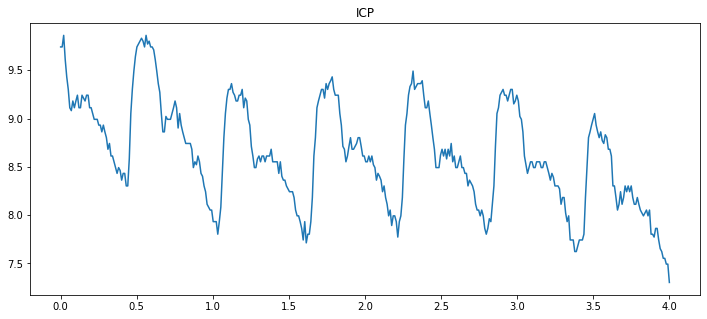

In [3]:
N = 400
fs = 100 
icp = f.icp(N)
t = torch.linspace(0, N/fs, N)

plt.figure(figsize=(12, 5))
plt.plot(t, icp)
plt.title('ICP')
print(f'> loaded {N} points at 100 Hz:')

### Spectral filtering

In [4]:
from torch.fft import fft, ifft, rfft, irfft
from sig.filter import Heat

In [26]:
kernel = Heat(1.6)

icp_f = kernel(icp)

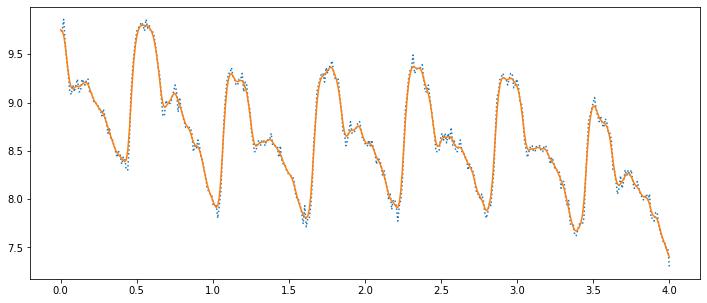

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(t, icp, linestyle='dotted')
plt.plot(t, icp_f)

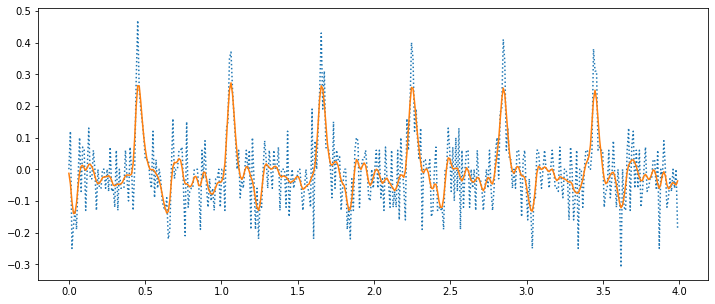

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(t[:-1], torch.diff(icp), linestyle="dotted")
plt.plot(t[:-1], torch.diff(icp_f))

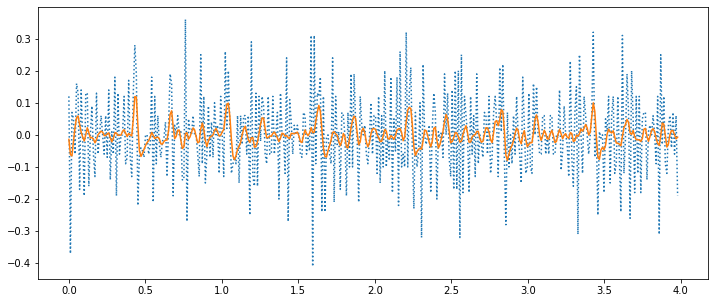

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(t[:-2], torch.diff(torch.diff(icp)), linestyle="dotted")
plt.plot(t[:-2], torch.diff(torch.diff(icp_f)))

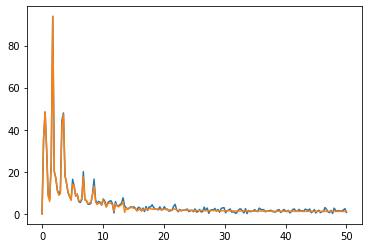

In [8]:
def center(tensor): 
    return tensor - tensor.mean()

def fourier(tensor, f1, fmax=100):
    N = tensor.shape[0]
    return rfft(center(tensor))[:math.floor(N * f1 /(2 * fmax))]

def spectrum(tensor, fcut): 
    return torch.linspace(0, fcut / 2, tensor.shape[0])

fcut = 100
_icp = fourier(icp, fcut)
_icp_f = fourier(icp_f, fcut)
sp = spectrum(_icp, fcut)

plt.plot(sp, _icp.abs())
plt.plot(sp, _icp_f.abs())